## Imports

In [21]:
import pandas as pd
import numpy as np
import os
import re
import traceback
import requests

from collections import Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as progress

from crossref.restful import Prefixes, Works, Journals

%config InlineBackend.figure_formats = ['svg']

## Load dataframe

In [3]:
record_dir = './arxiv-data/records'
frames = []
for feather in os.listdir(record_dir):
    if os.path.isdir(feather):
        continue
    if not feather.endswith('.feather'):
        continue
    frame = pd.read_feather(os.path.join(record_dir, feather))
    frames.append(frame)

records = pd.concat(frames)

print('Total record count {}'.format(records.shape[0]))

Total record count 140567


## Filtering

In [4]:
# Filter out all records without a DOI
records = records[records.doi != '']

print('Records with a doi {}'.format(records.shape[0]))

Records with a doi 115803


In [5]:
# Compile a list of all publishers present
publishers = list([doi.split('/')[0] for doi in records['doi'].to_list() if doi])
counts = dict(Counter(publishers))

In [6]:
min_record_counts = np.logspace(0, 5, num=30)
pub_count = np.zeros(min_record_counts.shape)
total_record_count = np.zeros(min_record_counts.shape)

for i, min_record_count in progress(
    enumerate(min_record_counts), 
    total=len(min_record_counts)
):

    # Compile a list of all publishers with more than n records
    publishers_filtered = [pub for pub, count in counts.items() 
                           if count > min_record_count]
    
    pub_count[i] = len(publishers_filtered)

    records_filtered = []
    
    for pub in publishers_filtered:
        record_count = records[records.doi.str.startswith(pub + '/')].shape[0]
        total_record_count[i] += record_count

# Get the publisher names

In [52]:
prefixes = Prefixes()

# Takes a few minutes, we might want to optimize this.
names = {prefix: prefixes.prefix(prefix) for prefix in counts}

In [63]:
data = pd.DataFrame(names).T
counts = pd.Series(counts)
data['count'] = counts

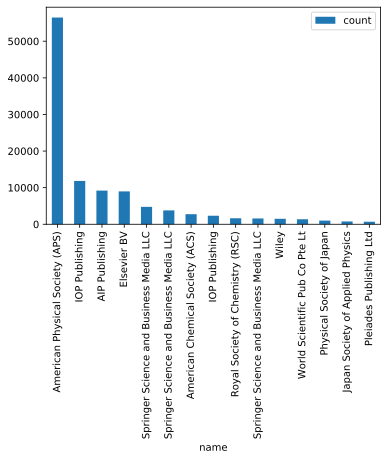

In [73]:
(
    data
    .sort_values(by='count', ascending=False)
    .head(15)
    .plot(x='name', y='count', kind='bar')
)

## Plot 1

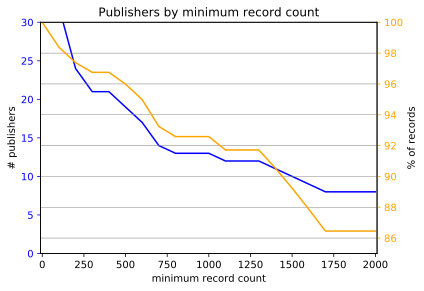

In [159]:
fig, ax1 = plt.subplots()
ax1.plot(min_record_counts, pub_count, color='b')
ax1.set(ylim=(0, 30))
ax1.tick_params('y', colors='b')
ax1.set_ylabel('# publishers')
ax1.set(xlim=(-10, 2010))
ax1.set_xlabel('minimum record count')

ax2 = ax1.twinx()
ax2.plot(min_record_counts, 
         total_record_count * 100 / records.shape[0],
         color='orange')
ax2.set(ylim=(85, 100))
ax2.tick_params('y', colors='orange')
ax2.set_ylabel('% of records')

plt.grid(color='gray', linestyle='-', linewidth=0.5)
fig.tight_layout()
plt.title('Publishers by minimum record count')
plt.show()

## Plot 2

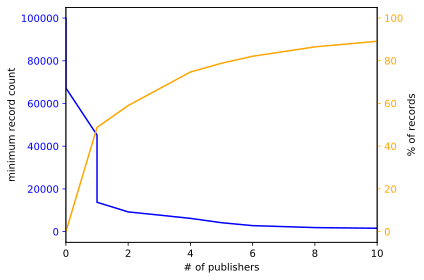

In [173]:
fig, ax1 = plt.subplots()
ax1.plot(pub_count, min_record_counts, color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylabel('minimum record count')
ax1.set_xlabel('# of publishers')
ax1.set(xlim=(0, 10))

ax2 = ax1.twinx()
ax2.plot(pub_count, 
         total_record_count * 100 / records.shape[0],
         color='orange')
ax2.tick_params('y', colors='orange')
ax2.set_ylabel('% of records')
fig.tight_layout()
plt.show()

In [8]:
# Compile a list of all publishers with more than n records
min_record_count = 10000
counts = dict(Counter(publishers))
publishers_filtered = [pub for pub, count in counts.items() 
                       if count > min_record_count]

publishers_filtered += ['10.1126', '10.1038']

records_filtered = []
for pub in publishers_filtered:
    records_filtered.append(records[records.doi.str.startswith(pub)])

records = pd.concat(records_filtered)

In [11]:
for j in publishers_filtered:
    print(j, counts[j])
print('total', sum(counts[j] for j in publishers_filtered))

10.1088 11844
10.1103 56476
10.1126 468
10.1038 4751
total 73539


## Create empty ISSN column

In [12]:
records['issn'] = ''

## Journal ISSN rules

In [13]:
# The rules generated by the script below.
# Saved here for efficiency
rules = {
    '10.1103': {
        'PhysRevA.': '1050-2947',
        'PhysRevB.': '1098-0121',
        'PhysRevC.': '0556-2813',
        'PhysRevD.': '2470-0010',
        'PhysRevE.': '1539-3755',
        'PhysRevX.': '2160-3308',
        'PhysRevLett.': '0031-9007',
        'Physics.': '1943-2879',
        'RevModPhys.': '0034-6861',
        'PhysRevApplied.': '2331-7019',
        'PhysRevFluids.': '2469-990X',
        'PhysRevMaterials.': '2475-9953',
        'PhysRevSTAB.': '1098-4402',
        'PhysRevAccelBeams.': '2469-9888',
    },
    '10.1126': {
        'science.': '0036-8075', 
        'sciadv.': '2375-2548',
    },
    '10.1038': {
        'ncomms': '2041-1723',
        'srep': '2045-2322',
        'nphys': '1745-2473',
        'nature': '0028-0836',
        'nnano': '1748-3387',
        'nmat': '1476-1122',
        'nphoton': '1749-4885',
        'nchem': '1755-4330',
        'lsa': '2047-7538',
        'am': '1884-4049',
        's41467': '2041-1723',
        's41534-': '2056-6387',
        's41598-': '2045-2322',
        's41535-': '2397-4648',
        's41559-': '2397-334X',
        'sdata.': '2052-4463',
        'natrevmats.': '2058-8437',
        'npjcompumats.': '2057-3960',
        'npjquantmats.': '2397-4648',
        'nenergy.': '2058-7546',
        's41699-': '2397-7132',
        's41524-': '2057-3960',
        's41566-': '1749-4885',
        's41567-': '1745-2473',
        's41565-': '1748-3387',
        's42005-': '2399-3650',
        's41563-': '1476-1122',
        's41893-': '2398-9629',
        's41928-': '2520-1131',
        's41560-': '2058-7546',
        's41578-': '2058-8437',
        's41586-': '0028-0836',
        's41377-': '2047-7538',
        's41427-': '1884-4049',
        's41592-': '1548-7091',
        's41557-': '1755-4330',
        's41570-': '2397-3358',
        'd41586-': '0028-0836',
        'npjqi.': '2056-6387',
        'micronano.': '2055-7434',
        's41562-': '2397-3374',
        'nn.': '1097-6256',
        'protex.': '2043-0116'
    }
}

## Resolve ISSNs

In [18]:
works = Works()

for index, record in progress(records.iterrows(), total=records.shape[0]):
    try:
        pub, identifier = record['doi'].split('/', 1)
    except ValueError:
        print('Unknown ISSN format: {}'.format(record['doi']))

    if pub in rules.keys():
        for key, value in rules[pub].items():
            if identifier.lower().startswith(key.lower()):
                record['issn'] = value
                break

        if not record['issn']:
            work = works.doi(record['doi'])
            if not work or 'ISSN' not in work.keys():
                print('Unknown ISSN for {}/{}'.format(pub, identifier))
            else:
                issn = work['ISSN'][0]
                record['issn'] = issn
                
                # Add new entry to the rules
                possible_journal = re.findall(r'^\w+[-_./]', identifier)
                if possible_journal:
                    journal = possible_journal[0]
                    rules[pub][journal] = issn
                    print('Got new ISSN rule {}/{}: {}'.format(pub, journal, issn))
              
    elif pub == '10.1088':
        issn = identifier.split('/', 1)[0]
        if re.match(r'^[0-9]{4}\-?[0-9]{3}[0-9Xx]$', issn):
            if len(issn) == 8:
                issn = '{}-{}'.format(issn[:4], issn[-4:])
            record['issn'] = issn
        else:
            print('Unknown ISSN for {}/{}'.format(pub, identifier))

Unknown ISSN for 10.1088/978-1-627-05532-1
Unknown ISSN for 10.1088/6102/44/3/431
Unknown ISSN for 10.1088/6102/44/6/1095
Unknown ISSN for 10.1088/6102/44/1/171
Unknown ISSN for 10.1088/1/1367-2630/13/6/068001
Unknown ISSN for 10.1103/Phys.RevE85.011131
Unknown ISSN for 10.1103/PhysRevB82.094203
Unknown ISSN format: 10.1103
Unknown ISSN for 10.1103/PhyRevLett.106.094502
Unknown ISSN for 10.1103/PhysRevB87.014506
Unknown ISSN for 10.1038/spre23114



## Without ISSN

In [19]:
records[records.issn == '']

id                                              title  \
254           1402.1205  Thermodynamic Properties of the van der Waals ...   
40037  cond-mat/0505440                Target-searching on the percolation   
40150  cond-mat/0508065  Interaction of a surface acoustic wave with a ...   
42466  quant-ph/0407100  Exact Numerical Solution of the BCS Pairing Pr...   
166           0904.3703  Comment on "No quantum friction between unifor...   
1555          1106.0780  Diffusion-mediated geminate reactions under ex...   
6091          1005.0189  Two-dimensional electron systems beyond the di...   
10653         1409.0145                                   Quantum friction   
8253          1304.0639  Millimeter-wave surface impedance of optimally...   
9750         1602.06684  Flexible heat-flow sensing sheets based on the...   

                               categories  \
254         cond-mat.soft physics.chem-ph   
40037  cond-mat.stat-mech cond-mat.dis-nn   
40150                   cond-mat.mes-hall   
42466          quant-ph cond-mat.supr-con   
166                        cond-mat.other   
1555   cond-mat.stat-mech physics.chem-ph   
6091                      cond-mat.dis-nn   
10653                   cond-mat.mes-hall   
8253                    cond-mat.supr-con   
9750                    cond-mat.mtrl-sci   

                                                abstract  \
254    The van der Waals (vdW) theory of fluids is th...   
40037  We study target-searching processes on a perco...   
40150  When a surface acoustic wave propagates on the...   
42466  We propose a new simulation computational meth...   
166    Quite recently Philbin et al present new theor...   
1555   In this paper, influence of crowding by inert ...   
6091   Transport properties of disordered electron sy...   
10653  We investigate the van der Waals friction betw...   
8253   Precision measurements of active and reactive ...   
9750   We demonstrated a flexible thermoelectric (TE)...   

                                   doi     created     updated  \
254          10.1088/978-1-627-05532-1  2014-02-05               
40037            10.1088/6102/44/3/431  2005-05-18               
40150           10.1088/6102/44/6/1095  2005-08-01               
42466            10.1088/6102/44/1/171  2004-07-14  2004-11-24   
166    10.1088/1/1367-2630/13/6/068001  2009-04-23  2009-05-14   
1555        10.1103/Phys.RevE85.011131  2011-06-03  2011-10-11   
6091         10.1103/PhysRevB82.094203  2010-05-03  2010-07-21   
10653    10.1103/PhyRevLett.106.094502  2014-08-30               
8253         10.1103/PhysRevB87.014506  2013-04-02               
9750                 10.1038/spre23114  2016-02-22               

                                                 authors issn  
254                                             Johnston       
40037                                               Yang       
40150                                     Yang, Zhao, Yu       
42466                            Xu, Wang, Yang, You, Ma       
166                                   Volokitin, Persson       
1555                               Seki, Wojcik, Tachiya       
6091                                              Markos       
10653                                 Volokitin, Persson       
8253   Barannik, Cherpak, Tanatar, Vitusevich, Skresa...       
9750   Kirihara, Kondo, Ishida, Ihara, Iwasaki, Somey...

## With ISSN

In [25]:
journals = Journals()

# Takes around a minute to fetch
journal_info = {issn: journals.journal(issn) for issn in records.issn.unique()}

In [111]:
journal_names = {issn: info['title'] if 'title' in info.keys() else 'Unknown' 
                 for issn, info in journal_info.items() if info}

journal_counts = dict(Counter(records.issn))

journal_data = pd.DataFrame([journal_names]).T
journal_data.index.name = 'issn'
journal_data.rename(columns={0: 'title'}, inplace=True)

count_data = pd.Series(journal_counts, name='count')
journal_data['count'] = count_data

In [115]:
print('# of journals: {}'.format(journal_data.shape[0]))
print('# of records: {}'.format(records[records.issn != ''].shape[0]))

# of journals: 126
# of records: 73529


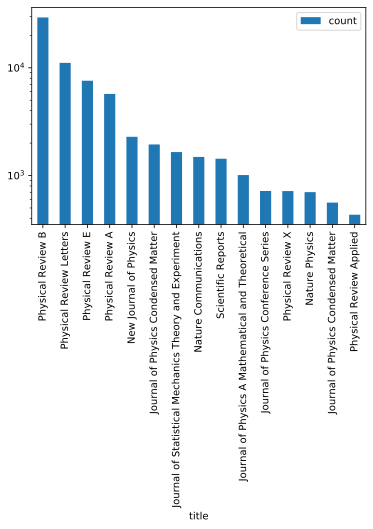

In [112]:
(
    journal_data
    .sort_values(by='count', ascending=False)
    .head(15)
    .plot(x='title', y='count', kind='bar')
)
plt.yscale('log')
plt.show()